In [67]:
import pandas as pd
import trimesh

obj_path = "Megalodon.obj"
obj = trimesh.load(obj_path)
# print(obj)
# print(obj.vertices)
vertices, faces = obj.vertices, obj.faces
print(vertices.shape)
print(faces.shape)

(524988, 3)
(1000000, 3)


In [68]:
vertices, faces = vertices.tolist(), faces.tolist()
df_vertices = pd.DataFrame(vertices, columns=["x", "y", "z"]) 
df_faces = pd.DataFrame(faces, columns=["v1", "v2", "v3"])
print(df_vertices)
print(df_faces)
vertex_csv, face_csv = "Megalodon_vertices.csv", "Megalodon_faces.csv"
df_vertices.to_csv(vertex_csv, index=False)
df_faces.to_csv(face_csv, index=False)
print("Done")

                x          y          z
0       27.090515  14.942806  10.662739
1       45.840515  27.542805 -32.434608
2       39.390514 -17.757193  22.540222
3       29.190514  32.845871 -37.168991
4       27.181568  14.942806  10.531005
...           ...        ...        ...
524983 -44.609482   7.859371  -3.568995
524984  -7.337589 -26.607191  16.531004
524985 -16.559483  17.201960   0.631005
524986 -44.840160   7.742806  -3.418995
524987 -43.800655   8.792807  -9.268994

[524988 rows x 3 columns]
            v1      v2      v3
0         6611  193242  193399
1         6611    6615  193242
2         6615  193186  193242
3         6641    6615    6611
4         6641  192497    6615
...        ...     ...     ...
999995  161486  161496  161493
999996   41532   27043   27009
999997  447843  160592  160604
999998  241889  241879  241882
999999  241860  241879  241889

[1000000 rows x 3 columns]
Done


In [69]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

def load_obj_vertices(filename):
    vertices = []
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith('v '):
                vertex = list(map(float, line.strip().split()[1:]))
                vertices.append(vertex)
    return np.array(vertices)

points = load_obj_vertices('Megalodon.obj')
raw_x, raw_y, raw_z = points[:, 0], points[:, 1], points[:, 2]
x_min, x_max = raw_x.min(), raw_x.max()
y_min, y_max = raw_y.min(), raw_y.max()
resolution = 100
x_coords = np.linspace(x_min, x_max, resolution)
y_coords = np.linspace(y_min, y_max, resolution)
X, Y = np.meshgrid(x_coords, y_coords)
Z_grid = griddata((raw_x, raw_y), raw_z, (X, Y), method='cubic')
Z_flat, X_flat, Y_flat = Z_grid.flatten(), X.ravel(), Y.ravel()
valid = ~np.isnan(Z_flat)
data_points = np.column_stack((X_flat[valid], Y_flat[valid], Z_flat[valid]))
np.savetxt("Megalodon_tooth_grid.csv", data_points, delimiter=",", header="X,Y,Z", comments="")
print("Done")

Done


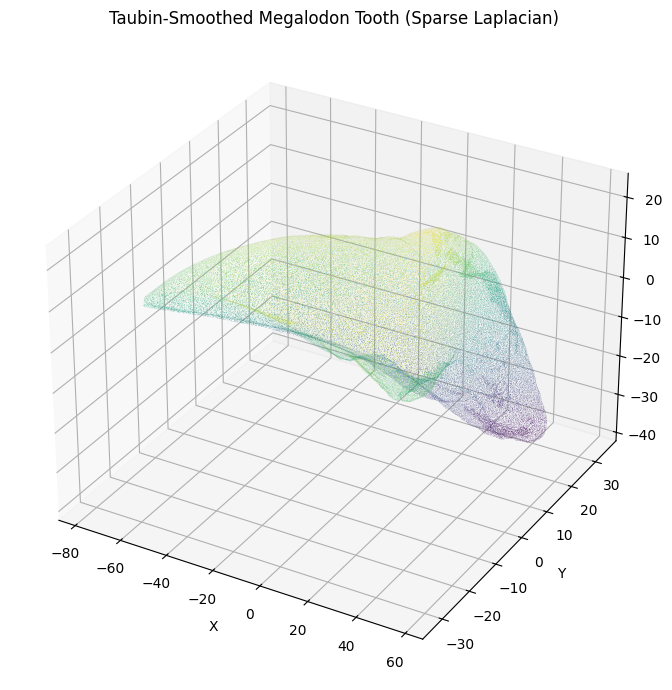

In [70]:
import numpy as np
import trimesh
from scipy.sparse import coo_matrix
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# Parameters
# ---------------------------------------------------------
steps = 4
plot_step = 10
adj_steps = 8

# ---------------------------------------------------------
# Symmetric adjacency matrix from faces
# ---------------------------------------------------------
def sym_adj_mat(F, N):
    """Build symmetric adjacency matrix A (N x N) from triangular faces F."""
    rows, cols = [], []
    for tri in F:
        a, b, c = tri
        rows.extend([a, b, b, c, c, a])
        cols.extend([b, a, c, b, a, c])
    data = np.ones(len(rows), dtype=float)
    A = coo_matrix((data, (rows, cols)), shape=(N, N)).tocsr()
    return A

def vertex_degrees(A):
    return np.array(A.sum(axis=1)).ravel()

# ---------- Boundary detection ----------
def boundary_vertex_mask(F, N):
    """
    Returns a boolean mask of length N:
    mask[i] = True if vertex i belongs to a boundary edge
    (edge that appears only once).
    """
    edges = np.vstack([
        F[:, [0, 1]],
        F[:, [1, 2]],
        F[:, [2, 0]],
    ])
    edges_sorted = np.sort(edges, axis=1)
    edk, edc = np.unique(edges_sorted, axis=0, return_counts=True)
    boundary_edges = edk[edc == 1]           # edges used only once
    boundary_verts = np.unique(boundary_edges.ravel())
    mask = np.zeros(N, dtype=bool)
    mask[boundary_verts] = True
    return mask

# ---------------------------------------------------------
# (Optional) grid-based Laplacian/Taubin smoothing on height map
# ---------------------------------------------------------
def laplacian_smooth(Z, iters=10, lam=0.3):
    Zs = Z.copy()
    for _ in range(iters):
        nb = (
            np.roll(Zs, 1, axis=0) +
            np.roll(Zs, -1, axis=0) +
            np.roll(Zs, 1, axis=1) +
            np.roll(Zs, -1, axis=1)
        ) / 4.0
        Zs = Zs + lam * (nb - Zs)
    return Zs

def taubin_smooth_grid(Z, iters=10, lam=0.5, mu=-0.53):
    Zs = Z.copy()
    for _ in range(iters):
        # λ-step
        nb = (
            np.roll(Zs, 1, axis=0) +
            np.roll(Zs, -1, axis=0) +
            np.roll(Zs, 1, axis=1) +
            np.roll(Zs, -1, axis=1)
        ) / 4.0
        Zs = Zs + lam * (nb - Zs)
        # μ-step
        nb = (
            np.roll(Zs, 1, axis=0) +
            np.roll(Zs, -1, axis=0) +
            np.roll(Zs, 1, axis=1) +
            np.roll(Zs, -1, axis=1)
        ) / 4.0
        Zs = Zs + mu * (nb - Zs)
    return Zs

# ---------------------------------------------------------
# Taubin smoothing on mesh with sparse normalized Laplacian
# (this is the core you want to match the "desired" version)
# ---------------------------------------------------------
# ---------- Taubin smoothing with pinned boundary ----------
# ---------- Taubin smoothing with pinned boundary ----------
def taubin_smooth_sparse(V, A, deg, boundary_mask,
                         iters=80, lam=0.5, mu=-0.53):
    """
    V: (N,3) vertices
    A: adjacency (N,N) sparse
    deg: (N,) degrees
    boundary_mask: (N,) bool, True for boundary verts to keep fixed
    """
    V0 = V.copy()               # original for pinned boundaries
    V  = V.copy()
    deg_col = deg[:, None]      # (N,1) for broadcasting

    for _ in range(iters):
        # λ-step
        AV = A.dot(V)
        LV = AV / deg_col - V   # normalized uniform Laplacian
        V  = V + lam * LV
        # pin boundary back to original
        V[boundary_mask] = V0[boundary_mask]

        # μ-step
        AV = A.dot(V)
        LV = AV / deg_col - V
        V  = V + mu * LV
        # pin again
        V[boundary_mask] = V0[boundary_mask]

    return V

# ---------------------------------------------------------
# (Optional) height-map reconstruction & smoothing from scattered data
# ---------------------------------------------------------
# data = np.loadtxt("Megalodon_tooth_grid.csv", delimiter=",", skiprows=1)
# Xc, Yc, Zc = data[:, 0], data[:, 1], data[:, 2]
# res = 1000
# xlin = np.linspace(Xc.min(), Xc.max(), res)
# ylin = np.linspace(Yc.min(), Yc.max(), res)
# Xg, Yg = np.meshgrid(xlin, ylin)
# Zlin = griddata((Xc, Yc), Zc, (Xg, Yg), method='cubic')
# Zn = griddata((Xc, Yc), Zc, (Xg, Yg), method='nearest')
# Zg = np.where(np.isnan(Zlin), Zn, Zlin)
# Z_taubin_grid = taubin_smooth_grid(Zg, iters=20, lam=0.5, mu=-0.53)

# ---------------------------------------------------------
# Mesh Taubin smoothing (this is the "desired" pipeline)
# ---------------------------------------------------------
V = np.loadtxt("Megalodon_vertices.csv", delimiter=",", skiprows=1)
F = np.loadtxt("Megalodon_faces.csv", delimiter=",", skiprows=1, dtype=int)

# If faces in file are 1-based, shift to 0-based:
if F.min() == 1:
    F = F - 1

N = V.shape[0]
A = sym_adj_mat(F, N)
deg = vertex_degrees(A)
deg[deg == 0] = 1.0

boundary_mask = boundary_vertex_mask(F, N)

V_smooth = taubin_smooth_sparse(
    V, A, deg, boundary_mask,
    iters=80, lam=0.5, mu=-0.53
)

# ---------------------------------------------------------
# Save smoothed vertices (CSV)
# ---------------------------------------------------------
out_csv = "Megalodon_vertices_taubin80.csv"
np.savetxt(out_csv, V_smooth,
           delimiter=",", header="x,y,z", comments="")

# ---------------------------------------------------------
# Export full-resolution PLY mesh
# ---------------------------------------------------------
ply_path = "Megalodon_taubin80_full.ply"
with open(ply_path, "w") as f:
    f.write("ply\nformat ascii 1.0\n")
    f.write(f"element vertex {len(V_smooth)}\n")
    f.write("property float x\nproperty float y\nproperty float z\n")
    f.write(f"element face {len(F)}\n")
    f.write("property list uchar int vertex_indices\n")
    f.write("end_header\n")
    for p in V_smooth:
        f.write(f"{p[0]} {p[1]} {p[2]}\n")
    for tri in F:
        f.write(f"3 {tri[0]} {tri[1]} {tri[2]}\n")

# ---------------------------------------------------------
# Lightweight 3D visualization using decimated faces
# ---------------------------------------------------------
F_plot = F[::adj_steps]

fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection="3d")
ax.plot_trisurf(
    V_smooth[:, 0], V_smooth[:, 1], V_smooth[:, 2],
    triangles=F_plot,
    cmap="viridis",
    alpha=0.9,
    linewidth=0.05
)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Taubin-Smoothed Megalodon Tooth (Sparse Laplacian)")
plt.tight_layout()
plt.show()

In [71]:
def check_watertight(V, F, tol=1e-12, oppo=-0.5):
    """Check if mesh is watertight (all faces are oriented consistently)."""
    edges = np.vstack([
        F[:, [0, 1]],
        F[:, [1, 2]],
        F[:, [2, 0]],
    ])
    edges_sorted = np.sort(edges, axis=1)
    # edu: unique edges, edc: counts
    edu, edc = np.unique(edges_sorted, axis=0, return_counts=True)
    boundary_edges = edu[edc == 1]           # edges used only once
    nonmanifold_edges = edu[edc > 2]         # edges used more than twice
    p0, p1, p2 = V[F[:, 0]], V[F[:, 1]], V[F[:, 2]]
    N = np.cross(p1 - p0, p2 - p0)
    norm = np.linalg.norm(N, axis=1)
    degenerate_faces = np.where(norm < tol)[0]
    N_norm = N.copy()
    mask = norm > tol
    N_norm[mask] = N_norm[mask] / norm[mask][:, None]
    
    # adjacency check
    edges_to_faces = {}
    for fi, tri in enumerate(F):
        for e in [(tri[0], tri[1]), (tri[1], tri[2]), (tri[2], tri[0])]:
            if e in edges_to_faces:
                edges_to_faces[e].append(fi)
            else:
                edges_to_faces[e] = [fi]
    inconsistent_normal_pairs = set()
    for e, faces in edges_to_faces.items():
        if len(faces) == 2:
            fi1, fi2 = faces
            if np.dot(N_norm[fi1], N_norm[fi2]) < oppo:
                inconsistent_normal_pairs.add((fi1, fi2))
    watertight = (len(boundary_edges) == 0) and (len(nonmanifold_edges) == 0)
    manifold = (len(degenerate_faces) == 0)
    orientable = (len(inconsistent_normal_pairs) == 0)
    return {
        "num_vertices": V.shape[0],
        "num_faces": F.shape[0],
        "num_boundary_edges": len(boundary_edges),
        "num_nonmanifold_edges": len(nonmanifold_edges),
        "num_degenerate_faces": len(degenerate_faces),
        "num_inconsistent_normals": len(inconsistent_normal_pairs),
        "is_watertight_topologically": watertight,
        "is_manifold_mesh": manifold,
        "is_orientable_normals": orientable,
        "is_waterproof": (watertight and orientable and manifold),
        "boundary_edges": boundary_edges,
        "nonmanifold_edges": nonmanifold_edges,
        "degenerate_faces": degenerate_faces,
        "inconsistent_normal_pairs": inconsistent_normal_pairs
    }
    
def aabb_overlap(min1, max1, min2, max2):
    return np.all(min1 <= max2) and np.all(min2 <= max1)

In [72]:
newF, newV = F_plot.copy(), V_smooth.copy()
ply_path = "Megalodon_taubin80_simplified_oriented.ply"
with open(ply_path, "w") as f:
    f.write("ply\nformat ascii 1.0\n")
    f.write(f"element vertex {len(newV)}\n")
    f.write("property float x\nproperty float y\nproperty float z\n")
    f.write(f"element face {len(newF)}\n")
    f.write("property list uchar int vertex_indices\n")
    f.write("end_header\n")
    for p in newV:
        f.write(f"{p[0]} {p[1]} {p[2]}\n")
    for tri in newF:
        f.write(f"3 {tri[0]} {tri[1]} {tri[2]}\n")
        
stl_path = "Megalodon_taubin80_simplified_oriented.stl"
# mesh = trimesh.Trimesh(vertices=V_smooth, faces=F_plot)
# mesh.export(stl_path)
with open(stl_path, "w") as f:
    f.write("solid megalodon_taubin80_simplified\n")
    v1, v2, v3 = newV[newF[:, 0]], newV[newF[:, 1]], newV[newF[:, 2]]
    n = np.cross(v2 - v1, v3 - v1)
    norms = np.linalg.norm(n, axis=1)
    norms[norms == 0] = 1.0
    n = n / norms[:, None]
    for i in range(len(newF)):
        f.write(f"facet normal {n[i, 0]} {n[i, 1]} {n[i, 2]}\n")
        f.write("outer loop\n")
        f.write(f"vertex {v1[i, 0]} {v1[i, 1]} {v1[i, 2]}\n")
        f.write(f"vertex {v2[i, 0]} {v2[i, 1]} {v2[i, 2]}\n")
        f.write(f"vertex {v3[i, 0]} {v3[i, 1]} {v3[i, 2]}\n")
        f.write("endloop\n")
        f.write("endfacet\n")
    f.write("endsolid megalodon_taubin80_simplified\n")

In [82]:
def aabb_encapsulation(V, F, eps=1e-8, multiplier=5,
                       use_broad_phase=True,
                       skip_shared_vertex=True,
                       print_examples=True):
    """
    Mesh diagnostics:
      - edge topology (boundary / non-manifold)
      - global AABB
      - edge length statistics (degenerate / unusually long edges)
      - optional: uniform-grid-accelerated edge–AABB broad-phase

    Returns a summary dict that can be re-used elsewhere.
    """
    # ---------------------------------------------------------
    # 1. Unique edges & basic edge topology
    # ---------------------------------------------------------
    edges = np.vstack([
        F[:, [0, 1]],
        F[:, [1, 2]],
        F[:, [2, 0]],
    ])  # (3 * num_faces, 2)
    edges_sorted = np.sort(edges, axis=1)

    # edk: unique edges (E, 2)
    # edc: counts for each unique edge
    # inv_idx: mapping from edges_sorted rows -> edk index
    edk, inv_idx, edc = np.unique(
        edges_sorted, axis=0, return_counts=True, return_inverse=True
    )
    num_unique_edges = edk.shape[0]

    boundary_mask = (edc == 1)
    nonmanifold_mask = (edc > 2)
    num_boundary_edges = int(np.sum(boundary_mask))
    num_nonmanifold_edges = int(np.sum(nonmanifold_mask))

    print("\nFull mesh topology check:")
    print("\tUnique edges      :", num_unique_edges)
    print("\tBoundary edges    :", num_boundary_edges)
    print("\tNon-manifold edges:", num_nonmanifold_edges)

    if num_boundary_edges == 0:
        print("\t✓ Watertight (no open boundary)")
    else:
        print("\t⚠ Open boundary edges present")

    if num_nonmanifold_edges == 0:
        print("\t✓ Manifold (no non-manifold edges)")
    else:
        print("\t⚠ Non-manifold edges present")

    # ---------------------------------------------------------
    # 2. Global AABB for the whole mesh
    # ---------------------------------------------------------
    mins, maxs = V.min(axis=0), V.max(axis=0)
    extent = maxs - mins
    diag = float(np.linalg.norm(extent))

    print("\nGlobal AABB:")
    print("\tMin xyz:", mins)
    print("\tMax xyz:", maxs)
    print("\tExtent :", extent)
    print("\tDiagonal length:", diag)

    # ---------------------------------------------------------
    # 3. Per-edge AABBs & edge-length statistics (for unique edges)
    # ---------------------------------------------------------
    v1, v2 = V[edk[:, 0]], V[edk[:, 1]]
    edge_mins = np.minimum(v1, v2)
    edge_maxs = np.maximum(v1, v2)
    edge_v = v2 - v1
    edge_norm = np.linalg.norm(edge_v, axis=1)

    norm_min, norm_max = float(edge_norm.min()), float(edge_norm.max())
    norm_mean, norm_median = float(edge_norm.mean()), float(np.median(edge_norm))
    length_mean = norm_mean  # used for long-edge threshold

    print("\nEdge length statistics (unique edges):")
    print("\tmin   :", norm_min)
    print("\tmax   :", norm_max)
    print("\tmean  :", norm_mean)
    print("\tmedian:", norm_median)

    eps_short = eps * diag
    short_mask = edge_norm < eps_short
    long_mask = edge_norm > multiplier * length_mean
    num_short = int(np.sum(short_mask))
    num_long = int(np.sum(long_mask))

    print("\nEdge quality (heuristic, unique edges):")
    print(f"\tShort edges (< {eps} * diag):", num_short)
    print(f"\tLong edges  (> {multiplier} * mean):", num_long)

    def inspect_edge(eid: int):
        i, j = edk[eid]
        print(f"\n[Edge #{eid}]  vertices: ({i}, {j})")
        print("\tlength:", float(edge_norm[eid]))
        print("\tv_i   :", V[i])
        print("\tv_j   :", V[j])
        print("\tAABB  : min =", edge_mins[eid], ", max =", edge_maxs[eid])
        print("\tused  :", int(edc[eid]), "time(s) in faces")

    if print_examples:
        if num_nonmanifold_edges > 0:
            print("\nNon-manifold edges (up to 10 shown):")
            for eid in np.where(nonmanifold_mask)[0][:10]:
                inspect_edge(int(eid))

        if num_boundary_edges > 0:
            print("\nBoundary edges (up to 10 shown):")
            for eid in np.where(boundary_mask)[0][:10]:
                inspect_edge(int(eid))

        if num_long > 0:
            print("\nLong edges (up to 10 shown):")
            for eid in np.where(long_mask)[0][:10]:
                inspect_edge(int(eid))

    # ---------------------------------------------------------
    # 4. Uniform-grid broad-phase (optional)
    # ---------------------------------------------------------
    candidate_pairs = []

    if use_broad_phase:
        origin = mins.copy()

        # Use the mean edge length as baseline for cell size,
        # clamped relative to the global diagonal.
        raw = length_mean if length_mean > 0 else diag * 0.01
        cell_size = float(np.clip(raw, 1e-4 * diag, 0.25 * diag))

        print("\nUniform grid parameters:")
        print("\torigin    :", origin)
        print("\tcell_size :", cell_size)

        grid = build_edge_uniform_grid(edge_mins, edge_maxs, origin, cell_size)
        print("\tGrid cells:", len(grid))

        candidate_pairs = find_candidate_edge_pairs(
            edge_mins,
            edge_maxs,
            grid,
            edge_keys=edk,
            skip_shared_vertex=skip_shared_vertex,
        )

        print("\nBroad-phase edge–edge candidate pairs:", len(candidate_pairs))

        if print_examples and len(candidate_pairs) > 0:
            print("\nExample candidate pairs (up to 5 shown):")
            for (eid_a, eid_b) in candidate_pairs[:5]:
                print(f"  pair: ({eid_a}, {eid_b})")
                inspect_edge(int(eid_a))
                inspect_edge(int(eid_b))

    # ---------------------------------------------------------
    # Summary result for further use
    # ---------------------------------------------------------
    summary = {
        "mins": mins,
        "maxs": maxs,
        "extent": extent,
        "diag": diag,
        "num_unique_edges": num_unique_edges,
        "num_boundary_edges": num_boundary_edges,
        "num_nonmanifold_edges": num_nonmanifold_edges,
        "edge_lengths": edge_norm,
        "short_mask": short_mask,
        "long_mask": long_mask,
        "edge_keys": edk,
        "edge_counts": edc,
        "edge_aabb_mins": edge_mins,
        "edge_aabb_maxs": edge_maxs,
        "candidate_pairs": candidate_pairs,
    }
    return summary

In [84]:
def build_kd_tree(V):
    """Wrapper to build a KDTree on vertices, if needed elsewhere."""
    from scipy.spatial import KDTree
    return KDTree(V)


def build_edge_uniform_grid(ed_mins, ed_maxs, origin, cell_size):
    """
    Build a uniform grid for edge AABBs.

    Parameters
    ----------
    ed_mins, ed_maxs : (E, 3) arrays
        Per-edge AABB minima and maxima.
    origin : (3,) array
        Grid origin (typically global AABB min).
    cell_size : float
        Grid cell edge length.

    Returns
    -------
    dict[(ix, iy, iz) -> list of edge indices]
    """
    grid = {}
    inv_cell = 1.0 / cell_size

    for i in range(ed_mins.shape[0]):
        min_cell = np.floor((ed_mins[i] - origin) * inv_cell).astype(int)
        max_cell = np.floor((ed_maxs[i] - origin) * inv_cell).astype(int)

        for x in range(min_cell[0], max_cell[0] + 1):
            for y in range(min_cell[1], max_cell[1] + 1):
                for z in range(min_cell[2], max_cell[2] + 1):
                    cell = (x, y, z)
                    if cell not in grid:
                        grid[cell] = []
                    grid[cell].append(i)

    return grid


def find_candidate_edge_pairs(ed_mins,
                              ed_maxs,
                              grid,
                              edge_keys,
                              skip_shared_vertex=True):
    """
    Find candidate edge pairs using the uniform grid
    (broad-phase AABB intersection).

    Parameters
    ----------
    ed_mins, ed_maxs : (E, 3)
        Per-edge AABB minima and maxima.
    grid : dict[(ix, iy, iz) -> list of edge indices]
        Built by `build_edge_uniform_grid`.
    edge_keys : (E, 2)
        Unique edge vertex indices (used to skip shared-vertex neighbors).
    skip_shared_vertex : bool
        If True, skip pairs of edges that share at least one vertex
        (i.e., we only report potentially “non-topological” interactions).

    Returns
    -------
    list of (eid1, eid2)
        Candidate edge index pairs.
    """
    candidate_pairs = set()

    if skip_shared_vertex:
        edge_vert_sets = [set(edge) for edge in edge_keys]
    else:
        edge_vert_sets = None

    for cell, edges_in_cell in grid.items():
        n = len(edges_in_cell)
        if n < 2:
            continue

        for i in range(n):
            eid_a = edges_in_cell[i]
            for j in range(i + 1, n):
                eid_b = edges_in_cell[j]

                # Optionally skip topologically adjacent edges
                if edge_vert_sets is not None:
                    if edge_vert_sets[eid_a] & edge_vert_sets[eid_b]:
                        continue

                if aabb_overlap(ed_mins[eid_a], ed_maxs[eid_a],
                                ed_mins[eid_b], ed_maxs[eid_b]):
                    if eid_a < eid_b:
                        pair = (eid_a, eid_b)
                    else:
                        pair = (eid_b, eid_a)
                    candidate_pairs.add(pair)

    return list(candidate_pairs)

In [85]:
# V_full = np.loadtxt("Megalodon_vertices_taubin80.csv", delimiter=",", skiprows=1)
# F_full = np.loadtxt("Megalodon_faces.csv", delimiter=",", skiprows=1, dtype=int)
# print("Loaded Taubin80 smoothed full mesh:")
# print("Vertices:", V_full.shape)
# print("Faces:", F_full.shape)

# edges_a = F_full[:, [0, 1]]
# edges_b = F_full[:, [1, 2]]
# edges_c = F_full[:, [2, 0]]
# edges = np.vstack((edges_a, edges_b, edges_c))
# sorted_edges = np.sort(edges, axis=1)
# edk, edc = np.unique(sorted_edges, axis=0, return_counts=True)
# boundary_edges = int(np.sum(edc == 1))
# nonmanifold_edges = int(np.sum(edc > 2))
# print("Total edges:", edges.shape[0])
# print("Unique edges:", edk.shape[0])

# print("Full-resolution mesh topology check:")
# print("Boundary edges:", boundary_edges)
# print("Manifold edges:", edges.shape[0] - boundary_edges - nonmanifold_edges)
# print("Nonmanifold edges:", nonmanifold_edges)
summary_topo = check_watertight(V_full, F_full)
df = pd.DataFrame([summary_topo])
print(df.to_string(index=False))

summary_aabb = aabb_encapsulation(V_full, F_full)
print("Candidate edge pairs (broad-phase):", len(summary_aabb["candidate_pairs"]))

 num_vertices  num_faces  num_boundary_edges  num_nonmanifold_edges  num_degenerate_faces  num_inconsistent_normals  is_watertight_topologically  is_manifold_mesh  is_orientable_normals  is_waterproof                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [75]:
import sys
!{sys.executable} -m pip --version
!{sys.executable} -m pip show networkx

pip 25.3 from /Users/eliguli712/.venv313/lib/python3.13/site-packages/pip (python 3.13)
Name: networkx
Version: 3.5
Summary: Python package for creating and manipulating graphs and networks
Home-page: https://networkx.org/
Author: 
Author-email: Aric Hagberg <hagberg@lanl.gov>
License: 
Location: /Users/eliguli712/.venv313/lib/python3.13/site-packages
Requires: 
Required-by: 


Min index: 0 Max index: 524987
Number of vertices: 524988


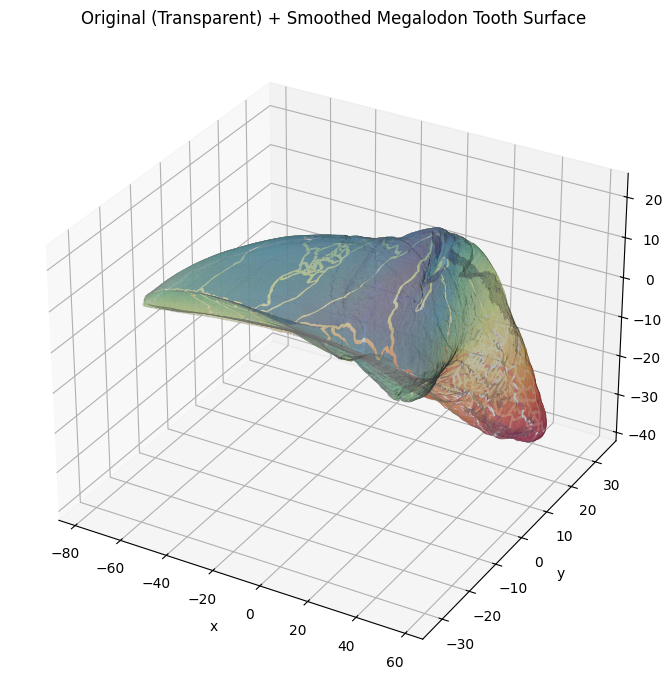

In [76]:
# ---------------------------------------------------------
# Parameters
# ---------------------------------------------------------
num_iters = 100
lam = 0.35

# ---------------------------------------------------------
# Laplacian smoothing function
# ---------------------------------------------------------
def laplacian_mesh_smooth(V, neighbours, iters=num_iters, lam=0.3):
    v = V.copy()
    for _ in range(iters):
        v_new = v.copy()
        for i in range(v.shape[0]):
            nb = neighbours[i]
            if len(nb) == 0:
                continue  # isolated vertex
            v_new[i] = lam * v[i] + (1 - lam) * np.mean(v[nb], axis=0)
        v = v_new
    return v

# ---------------------------------------------------------
# Load mesh
# ---------------------------------------------------------
# Load vertices
V = np.loadtxt("Megalodon_vertices.csv", delimiter=",", skiprows=1)

# Load raw faces
F_raw = np.loadtxt("Megalodon_faces.csv", delimiter=",", skiprows=1, dtype=int)

# 1. Determine if 1-indexed
if F_raw.min() == 1:
    F = F_raw - 1
else:
    F = F_raw

# 2. Remove invalid rows
F = F[(F >= 0).all(axis=1)]

# 3. Remove out-of-range rows
N = V.shape[0]
F = F[(F < N).all(axis=1)]

print("Min index:", F.min(), "Max index:", F.max())
print("Number of vertices:", N)

# ---------------------------------------------------------
# Build neighbour lists
# ---------------------------------------------------------
neighbours = [[] for _ in range(N)]
for a, b, c in F:
    neighbours[a].extend([b, c])
    neighbours[b].extend([a, c])
    neighbours[c].extend([a, b])

# Remove duplicates for stability
neighbours = [list(set(nb)) for nb in neighbours]

# ---------------------------------------------------------
# Apply smoothing
# ---------------------------------------------------------
V_smooth = laplacian_mesh_smooth(V, neighbours, iters=20, lam=lam)

np.savetxt("Megalodon_vertices_smooth.csv",
           V_smooth, delimiter=", ", fmt="%.6f")

# ---------------------------------------------------------
# Plot
# ---------------------------------------------------------
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection="3d")

# Optional transparent original mesh
ax.plot_trisurf(V[:, 0], V[:, 1], V[:, 2],
                triangles=F,
                color=(0.7, 0.7, 0.7, 0.2),
                linewidth=0)

# Smoothed mesh
ax.plot_trisurf(V_smooth[:, 0], V_smooth[:, 1], V_smooth[:, 2],
                triangles=F,
                cmap="Spectral",
                linewidth=0.05,
                alpha=0.95)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("Original (Transparent) + Smoothed Megalodon Tooth Surface")

plt.tight_layout()
plt.show()
